In [57]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
df_tourism = pd.read_csv('df_tourism_cleaned.csv') #read in cleaned df from data_prep file

In [59]:
df_tourism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3740 entries, 0 to 3739
Data columns (total 67 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3740 non-null   int64  
 1   host_id                                       3740 non-null   int64  
 2   host_since                                    3740 non-null   object 
 3   host_response_time_hours                      3740 non-null   float64
 4   host_response_rate                            3740 non-null   float64
 5   host_acceptance_rate                          3740 non-null   float64
 6   host_is_superhost                             3740 non-null   float64
 7   host_listings_count                           3740 non-null   int64  
 8   host_total_listings_count                     3740 non-null   int64  
 9   host_verifications                            3740 non-null   o

In [60]:
df_tourism.isna().sum()[df_tourism.isna().sum() > 0] #no need for imputer later bc no NaNs

Series([], dtype: int64)

In [61]:
# host_id duplicates (GroupKFold needed for CV later on host_id))
duplicate_hosts = df_tourism['host_id'].value_counts()
duplicate_hosts = duplicate_hosts[duplicate_hosts > 1]
print(duplicate_hosts)

host_id
487327       55
73995257     47
306041574    46
224865057    39
408542876    39
             ..
143444535     2
1401587       2
13376114      2
414108680     2
5054644       2
Name: count, Length: 487, dtype: int64


In [62]:
df_tourism.columns

Index(['id', 'host_id', 'host_since', 'host_response_time_hours',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_name', 'latitude', 'longitude', 'property_type',
       'room_type', 'nbr_accommodates', 'nbr_bathrooms', 'nbr_bedrooms',
       'nbr_beds', 'list_amenities', 'price_CAD', 'minimum_nights',
       'maximum_nights', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'nbr_of_reviews', 'nbr_of_reviews_ltm', 'nbr_of_reviews_l30d',
       'availability_eoy', 'nbr_of_reviews_ly', 'estimated_occupancy_l365d',
       'review_scores_rating', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_

In [63]:
numeric_features = ["nbr_bedrooms","nbr_bathrooms","nbr_beds","nbr_accommodates",
    "host_is_superhost", 'instant_bookable', 'host_response_time_hours', 'host_total_listings_count',
     'nbr_amenities', 'has_sauna', 'has_gym', 'has_air_conditioning',
       'has_heating', 'has_free_parking', 'has_pool', 'has_hot_tub',
       'has_balcony', 'has_fireplace', 'has_elevator', 'has_view',
       'has_dishwasher', 'is_entire_place',
       'has_shared_bath', 'dist_to_PVM_km', 'hosting_years',]

#decided not to include categorical as most if not all have been used as binary flags 

X = df_tourism[numeric_features]
y = df_tourism['price_CAD']
groups_all = df_tourism['host_id'].values

In [64]:
#train-test split with GroupShuffleSplit to avoid data leakage on host_id (keep all listings from same host in either train or test set)

from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42) #returns iterable of (train_idx, test_idx) tuples
train_idx, test_idx = next(gss.split(X, y, groups=df_tourism['host_id']))
X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]
groups_train, groups_test = groups_all[train_idx], groups_all[test_idx]


In [72]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor

steps_rf = [("imputation", SimpleImputer(strategy='median')), ("scaling",StandardScaler()), ("rf", RandomForestRegressor(random_state=42))] #Imputing in pipeline even though no NaNs in df to keep code modular if new features added later
pipeline_rf = Pipeline(steps_rf)

#train on log-transformed target to reduce impact of outliers and then reverse back to price_CAD (does it automatically)
transformed_target_reg = TransformedTargetRegressor(regressor=pipeline_rf,func = np.log1p, inverse_func=np.expm1) 



#GroupKFold CV on host_id to avoid model from learning host-specific features
results = cross_val_score(transformed_target_reg, X_train, y_train, cv=GroupKFold(n_splits=5), groups=groups_train, scoring='neg_mean_absolute_error', n_jobs=-1)



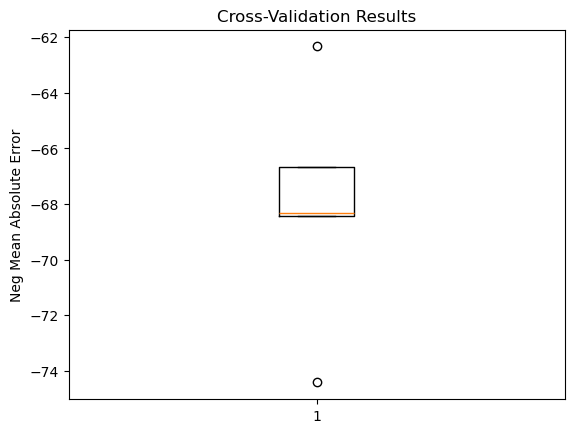

In [76]:
plt.boxplot(results)
plt.title('Cross-Validation Results')
plt.ylabel('Neg Mean Absolute Error')
plt.show()

In [74]:
results_mae = -results  # flip sign
print("Mean MAE:", results_mae.mean())
print("Std MAE:", results_mae.std())


Mean MAE: 68.03750087370398
Std MAE: 3.884252379129008


In [83]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = { "regressor__rf__n_estimators" : randint(100,900),
               "regressor__rf__max_depth":randint(3, 20),
               "regressor__rf__min_samples_leaf":randint(1, 7),
               "regressor__rf__max_features": [0.3,0.7]
               }

random_search = RandomizedSearchCV(transformed_target_reg, param_distributions=param_dist, n_iter=15, cv=GroupKFold(n_splits=5),
                                   scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42)

In [84]:
random_search.fit(X_train, y_train, groups=groups_train)
print("Best parameters found: ", random_search.best_params_)
print("Best CV score: ", -random_search.best_score_)
best_model = random_search.best_estimator_

Best parameters found:  {'regressor__rf__max_depth': 11, 'regressor__rf__max_features': 0.3, 'regressor__rf__min_samples_leaf': 2, 'regressor__rf__n_estimators': 487}
Best CV score:  65.03573420269255


In [85]:
from sklearn.metrics import mean_absolute_error
import numpy as np

baseline_pred = np.repeat(y_train.median(), len(y_train))
baseline_mae = mean_absolute_error(y_train, baseline_pred)
print("Baseline MAE:", baseline_mae)


Baseline MAE: 104.0646882294098


In [ ]:
best_model.fit(X_test, y_test)
y_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print("Test MAE:", test_mae) #off by 30$ on average from true price 

Test MAE: 29.92498160527195
